In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sqlite3
import matplotlib.pyplot as plt

## Preprocess the Data

## TODO: Add More Features

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
matches_open = open("/content/gdrive/My Drive/SoccerMatchPredictor/Match.csv","rb")
teams_open = open("/content/gdrive/My Drive/SoccerMatchPredictor/Team.csv","rb")

matches = pd.read_csv(matches_open) # matches df
teams = pd.read_csv(teams_open) # teams df (w/ team names)

matches['home_team'] = matches['home_team_api_id'].replace(teams.set_index('team_api_id')['team_long_name'])
matches['away_team'] = matches['away_team_api_id'].replace(teams.set_index('team_api_id')['team_long_name'])

print(m)
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_team,away_team
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,KRC Genk,Beerschot AC
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,SV Zulte-Waregem,Sporting Lokeren
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75,KSV Cercle Brugge,RSC Anderlecht
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50,KAA Gent,RAEC Mons
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67,FCV Dender EH,Standard de Liège


In [ ]:
#England, Italy, Spain, France, Germany
top_countries = [1729, 4769, 7809, 10257, 21518]

#Drop countries not in Top 5
matches = matches[matches['country_id'].isin(top_countries)]

#Keep only the following
matches = matches[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']]
#
matches

,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
1728,10260,10261,1,1
1729,9825,8659,1,0
1730,8472,8650,0,1
1731,8654,8528,2,1
1732,10252,8456,4,2
...,...,...,...,...
24552,9906,10267,2,1
24553,9864,9783,2,0
24554,8315,9869,3,0
24555,7878,8603,1,1


In [ ]:
#More Features model
homeWins = matches[matches['home_team_goal'] > matches["away_team_goal"]].groupby(
    ['home_team_api_id', 'away_team_api_id'])['home_team_goal'].count()
awayWins = matches[matches['home_team_goal'] < matches["away_team_goal"]].groupby(
    ['home_team_api_id', 'away_team_api_id'])['away_team_goal'].count()
draw = matches[matches['home_team_goal'] == matches["away_team_goal"]].groupby(
    ['home_team_api_id', 'away_team_api_id'])['home_team_goal'].count()
matchCount = matches.groupby(['home_team_api_id', 'away_team_api_id'])['home_team_goal'].count()

history = pd.concat([homeWins, awayWins, draw, matchCount], axis=1)
history.columns = ['homeWinCount', 'awayWinCount', 'drawCount', 'totalMatches']
history = history.reset_index()

teamIDs = matches[['home_team_api_id', 'away_team_api_id']].drop_duplicates()

history = pd.merge(teamIDs, history, on=['home_team_api_id', 'away_team_api_id'], how='left').fillna(0)

history


,home_team_api_id,away_team_api_id,homeWinCount,awayWinCount,drawCount,totalMatches
0,10260,10261,3.0,1.0,3.0,7
1,9825,8659,6.0,1.0,0.0,7
2,8472,8650,2.0,5.0,1.0,8
3,8654,8528,4.0,0.0,0.0,4
4,10252,8456,3.0,3.0,2.0,8
...,...,...,...,...,...,...
4344,8306,8302,1.0,0.0,0.0,1
4345,8634,8306,1.0,0.0,0.0,1
4346,8306,8372,0.0,1.0,0.0,1
4347,8305,8306,1.0,0.0,0.0,1


## Normalize Simple Data

In [ ]:
label = LabelEncoder()
#Fit label and return encoded labels for training data
matches["home_team_api_id"] = label.fit_transform(matches["home_team_api_id"])
#Transform to normalize for test data
matches["away_team_api_id"] = label.transform(matches["away_team_api_id"])

#Training
X = matches[["home_team_api_id", "away_team_api_id"]].values
#Test
y = (matches["home_team_goal"] > matches["away_team_goal"]).values


## Split Simple Data Into Training and Test Sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

## Normalize Complex Data


In [ ]:
#Fit label and return encoded labels for training data
history["home_team_api_id"] = label.fit_transform(history["home_team_api_id"])
#Transform to normalize for test data
history["away_team_api_id"] = label.transform(history["away_team_api_id"])

#Training
X_c = history[["home_team_api_id", "away_team_api_id", 'drawCount', 'totalMatches']].values
#Test
y_c = (history["homeWinCount"] > history["awayWinCount"]).values


## Split Complex Data Into Training and Test Sets


In [ ]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_c, y_c, test_size=0.2, random_state=46)
print(yc_test)

[ True False False False  True  True False False  True  True  True  True
  True False False  True False  True  True False False False False False
 False  True  True  True False False False False  True False False  True
 False False  True  True  True False False  True  True  True  True  True
 False  True False  True False False False  True  True False  True  True
  True  True False  True  True  True False  True False  True  True  True
 False  True False False  True  True False False  True  True False  True
  True  True False  True  True  True  True  True  True  True  True False
 False False  True False  True  True  True False  True False False  True
  True  True  True False  True  True  True False  True False  True False
 False  True  True  True  True False False  True False False False False
  True False  True  True False False False False False  True False False
  True  True  True False False False  True  True  True False False  True
  True False  True  True False False  True  True  T

## Create Neural Network Model

In [ ]:
class NeuralPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        # input layer
        self.fc1 = nn.Linear(2, 16) # 2 input, 16 output
        # hidden layer
        self.fc2 = nn.Linear(16, 32) # 16 input, 32 output
        # output layer
        self.fc3 = nn.Linear(32, 1) # 32 input, 1 output
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [ ]:
class NeuralPredictorC(nn.Module):
    def __init__(self):
        super().__init__()
        # input layer
        self.fc1 = nn.Linear(4, 16) # 4 input, 16 output
        # hidden layer
        self.fc2 = nn.Linear(16, 32) # 16 input, 32 output
        # output layer
        self.fc3 = nn.Linear(32, 1) # 32 input, 1 output
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

Test Model

In [ ]:
input = 4
hidden = 8
out = 1

test = nn.Sequential(
    nn.Linear(input, hidden),
    nn.ReLU(),
    nn.Linear(hidden, out),
    nn.Sigmoid()
)

## Train the Model w/ Simple Data

In [ ]:
model = NeuralPredictor()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)
num_epochs = 100
train_losses = []
valid_losses = []
for epochs in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(torch.FloatTensor(X_train))
    loss = criterion(out, torch.FloatTensor(y_train.reshape(-1, 1)))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
      outputs = model(torch.FloatTensor(X_test))
      loss = criterion(outputs, torch.FloatTensor(y_test.reshape(-1, 1)))
      valid_losses.append(loss.item())
      predictions = torch.round(outputs).flatten().numpy()
      accuracy = (predictions == y_test).mean()
print(accuracy)


0.5529653753856703


## TODO: Add Graphs


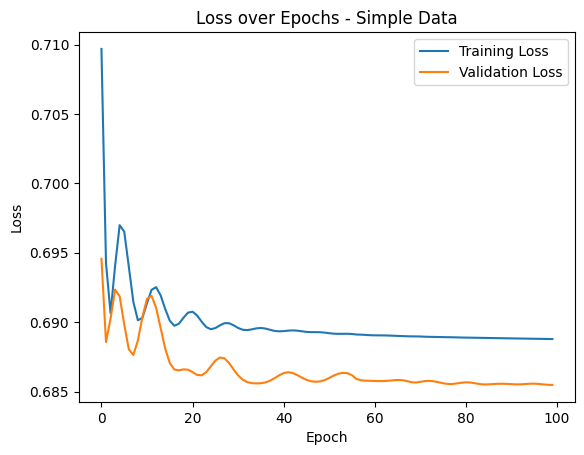

In [ ]:
#Add Loss Graphs
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), valid_losses, label='Validation Loss')
plt.title("Loss over Epochs - Simple Data")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Print Accuracy - Simple

## Train The Model on Complex Data

In [ ]:
model = NeuralPredictorC()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)
num_epochs = 100
train_losses = []
valid_losses = []
for epochs in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(torch.FloatTensor(Xc_train))
    loss = criterion(out, torch.FloatTensor(yc_train.reshape(-1, 1)))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
      outputs = model(torch.FloatTensor(Xc_test))
      loss = criterion(outputs, torch.FloatTensor(yc_test.reshape(-1, 1)))
      valid_losses.append(loss.item())
      predictions = torch.round(outputs).flatten().numpy()
      accuracy = (predictions == yc_test).mean()
print(accuracy)

0.5977011494252874


## Add Graphs

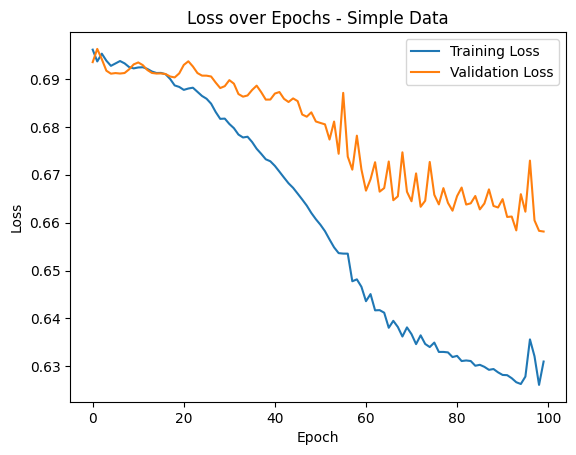

In [ ]:
#Add Loss Graphs
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), valid_losses, label='Validation Loss')
plt.title("Loss over Epochs - Simple Data")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
model = NeuralPredictorC()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)
num_epochs = 100
train_losses = []
valid_losses = []
for epochs in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(torch.FloatTensor(Xc_train))
    loss = criterion(out, torch.FloatTensor(yc_train.reshape(-1, 1)))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
      outputs = model(torch.FloatTensor(Xc_test))
      print(outputs)
      loss = criterion(outputs, torch.FloatTensor(yc_test.reshape(-1, 1)))
      valid_losses.append(loss.item())
      predictions = torch.round(outputs).flatten().numpy()
      accuracy = (predictions == yc_test).mean()
print(accuracy)

In [ ]:
def get_draw_count_and_total_matches(home_team_api_id, away_team_api_id):
    filtered = history.query(f"home_team_api_id == {home_team_api_id} & away_team_api_id == {away_team_api_id}")
    if not filtered.empty:
        draw_count = filtered["drawCount"].values[0]
        total_matches = filtered["totalMatches"].values[0]
        return draw_count, total_matches
    else:
        return 0, 0


In [ ]:
def predict(model, input_data):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.FloatTensor(input_data)
        predictions = model(input_tensor)
        rounded_predictions = torch.round(predictions).flatten().numpy()
    return rounded_predictions


In [ ]:
# Train the model using the provided code
def predict_2(team1_id, team2_id):
  draw_count, total_matches = get_draw_count_and_total_matches(team1_id,team2_id)
  data = [[team1_id, team2_id, draw_count, total_matches]]
  df = pd.DataFrame(data, columns=['id1', 'id2','id3','id4'])
  print(df.values)
  input_data = df.values  # Replace with your desired input data
  predicted_values = predict(model, input_data)
  print("Predicted values:", predicted_values)


In [ ]:
predict_2(84,91)

[[84 91  0  0]]
Predicted values: [0.]


In [ ]:
for i in range(50,150):
  for j in range(50,150):
    predict_2(i,j)

[[50 50  0  0]]
Predicted values: [0.]
[[50. 51.  2.  2.]]
Predicted values: [0.]
[[50. 52.  2.  8.]]
Predicted values: [1.]
[[50. 53.  0.  2.]]
Predicted values: [1.]
[[50. 54.  2.  7.]]
Predicted values: [1.]
[[50. 55.  1.  8.]]
Predicted values: [1.]
[[50 56  0  0]]
Predicted values: [0.]
[[50 57  0  0]]
Predicted values: [0.]
[[50. 58.  2.  4.]]
Predicted values: [1.]
[[50 59  0  0]]
Predicted values: [0.]
[[50 60  0  0]]
Predicted values: [0.]
[[50 61  0  0]]
Predicted values: [0.]
[[50. 62.  3.  8.]]
Predicted values: [1.]
[[50 63  0  0]]
Predicted values: [0.]
[[50 64  0  0]]
Predicted values: [0.]
[[50 65  0  0]]
Predicted values: [0.]
[[50 66  0  0]]
Predicted values: [0.]
[[50 67  0  0]]
Predicted values: [0.]
[[50 68  0  0]]
Predicted values: [0.]
[[50. 69.  4.  8.]]
Predicted values: [1.]
[[50 70  0  0]]
Predicted values: [0.]
[[50 71  0  0]]
Predicted values: [0.]
[[50 72  0  0]]
Predicted values: [0.]
[[50 73  0  0]]
Predicted values: [0.]
[[50. 74.  1.  8.]]
Predicted va

KeyboardInterrupt: ignored

## TODO: Interactive Function For Sports Prediction